# 1 Baseline Model (MLP)

## Load data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


In [3]:
# Load data
data = np.load(r"data\data.npy")
target = np.load(r"data\target.npy")

# Feature-wise scaling 
# reshape temporarily to [samples * time-steps , features] for feature-colums
# Code modified from https://stackoverflow.com/a/59601298

scaler = StandardScaler()
data = scaler.fit_transform(data.reshape(-1, data.shape[-1])).reshape(data.shape)
# TODO seperated train & test set scaling

print(data.shape,target.shape)

(400, 500, 3) (400,)


(400, 1500)

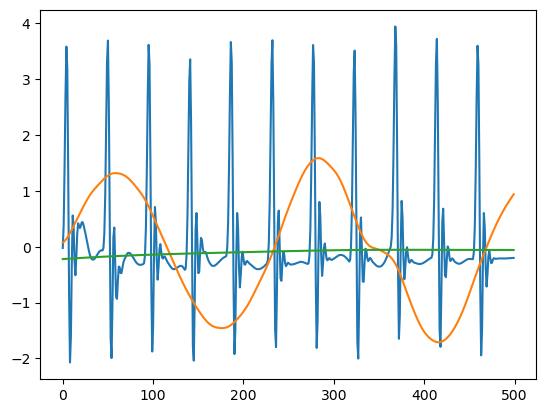

In [4]:
# Reshape data to 1-D for MLP
data_mlp = np.reshape(data, (
    data.shape[0],
    data.shape[2]*data.shape[1]
), order="F")

plt.plot(data[142]);
data_mlp.shape

## Sklearn implementation


In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data_mlp, target, stratify=target, random_state=1)

clf = MLPClassifier(random_state=1, max_iter=500).fit(X_train, y_train)

clf.score(X_test, y_test)


0.78

## Tensorflow implementation

In [60]:
# MLP model 
# Code modified from https://github.com/hfawaz/dl-4-tsc/blob/master/classifiers/mlp.py

import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import time

import matplotlib 
matplotlib.use('agg')
import matplotlib.pyplot as plt 

from utils.utils import save_logs
from utils.utils import calculate_metrics

class Classifier_MLP:

	def __init__(self, output_directory, input_shape, nb_classes, verbose=False,build=True):
		self.output_directory = output_directory
		if build == True:
			self.model = self.build_model(input_shape, nb_classes)
			if(verbose==True):
				self.model.summary()
			self.verbose = verbose
			self.model.save_weights(self.output_directory + 'model_init.hdf5')
		return

	def build_model(self, input_shape, nb_classes):
		input_layer = keras.layers.Input(input_shape)

		# flatten/reshape because when multivariate all should be on the same axis 
		input_layer_flattened = keras.layers.Flatten()(input_layer)
		
		layer_1 = keras.layers.Dropout(0.1)(input_layer_flattened)
		layer_1 = keras.layers.Dense(500, activation='relu')(layer_1)

		layer_2 = keras.layers.Dropout(0.2)(layer_1)
		layer_2 = keras.layers.Dense(500, activation='relu')(layer_2)

		layer_3 = keras.layers.Dropout(0.2)(layer_2)
		layer_3 = keras.layers.Dense(500, activation='relu')(layer_3)

		output_layer = keras.layers.Dropout(0.3)(layer_3)
		output_layer = keras.layers.Dense(nb_classes, activation='softmax')(output_layer)

		model = keras.models.Model(inputs=input_layer, outputs=output_layer)

		model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adadelta(),
			metrics=['accuracy'])

		reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=200, min_lr=0.1)

		file_path = self.output_directory+'best_model.hdf5' 

		model_checkpoint = keras.callbacks.ModelCheckpoint(filepath=file_path, monitor='loss', 
			save_best_only=True)

		self.callbacks = [reduce_lr,model_checkpoint]

		return model

	def fit(self, x_train, y_train, x_val, y_val,y_true):
		if not tf.test.is_gpu_available:
			print('error')
			exit()
		# x_val and y_val are only used to monitor the test loss and NOT for training  
		batch_size = 16
		nb_epochs = 5000

		mini_batch_size = int(min(x_train.shape[0]/10, batch_size))

		start_time = time.time() 

		hist = self.model.fit(x_train, y_train, batch_size=mini_batch_size, epochs=nb_epochs,
			verbose=self.verbose, validation_data=(x_val,y_val), callbacks=self.callbacks)
		
		duration = time.time() - start_time

		self.model.save(self.output_directory + 'last_model.hdf5')

		model = keras.models.load_model(self.output_directory+'best_model.hdf5')

		y_pred = model.predict(x_val)

		# convert the predicted from binary to integer 
		y_pred = np.argmax(y_pred , axis=1)

		save_logs(self.output_directory, hist, y_pred, y_true, duration)

		keras.backend.clear_session()

	def predict(self, x_test, y_true,x_train,y_train,y_test,return_df_metrics = True):
		model_path = self.output_directory + 'best_model.hdf5'
		model = keras.models.load_model(model_path)
		y_pred = model.predict(x_test)
		if return_df_metrics:
			y_pred = np.argmax(y_pred, axis=1)
			df_metrics = calculate_metrics(y_true, y_pred, 0.0)
			return df_metrics
		else:
			return 


ModuleNotFoundError: No module named 'tensorflow'

To do list
- add Group (stratified) k-fold cross-validation  